The model used is based on the code from this article: https://learnopencv.com/denoising-diffusion-probabilistic-models/.
Below is a tweaked version of that code which should work with the saved weights if you are trying to reproduce the model/results. The model probably needs to be run on a GPU as it is quite big, and so that is what this code is intended for. To run in colab, you will have to mount your google drive and have the weight file in there, changing the path to the weight file accordingly.

In [1]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import torchvision.transforms as TF
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
## Define layers:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)

        return h


class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)


class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, *args):
        return self.upsample(x)


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=128,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=4,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):

        time_emb = self.time_embeddings(t)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h

In [15]:
# Configure and instantiate model

from dataclasses import dataclass

@dataclass
class ModelConfig:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    IMG_SHAPE = (1,64,64)
    BASE_CH = 64  # 64, 128, 256, 256
    BASE_CH_MULT = (1, 2, 4, 4) # 32, 16, 8, 8
    APPLY_ATTENTION = (False, True, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128
    TIMESTEPS = 1000


model = UNet(
    input_channels          = ModelConfig.IMG_SHAPE[0],
    output_channels         = ModelConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.to(ModelConfig.DEVICE)


UNet(
  (time_embeddings): SinusoidalPositionEmbeddings(
    (time_blocks): Sequential(
      (0): Embedding(1000, 64)
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): SiLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (first): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (encoder_blocks): ModuleList(
    (0-1): 2 x ResnetBlock(
      (act_fn): SiLU()
      (normlize_1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (dense_1): Linear(in_features=256, out_features=64, bias=True)
      (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
      (dropout): Dropout2d(p=0.1, inplace=False)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (match_input): Identity()
      (attention): Identity()
    )
    (2): DownSample(
      (downsample): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1

In [16]:
# Load weights
weights = torch.load("model_statedict.pt", map_location=ModelConfig.DEVICE)
model.load_state_dict(weights)


<All keys matched successfully>

In [19]:
# Now we want to run inference on our model, so we define the necessary functions:
def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(1, 64, 64),
                      num_images=5, nrow=8, device=ModelConfig.DEVICE, **kwargs):

    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()


    for time_step in tqdm(iterable=reversed(range(1, timesteps)),
                          total=timesteps-1, dynamic_ncols=False,
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        predicted_noise = model(x, ts)

        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts)

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )


    x = inverse_transform(x).type(torch.uint8)
    grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
    pil_image = TF.functional.to_pil_image(grid)
    if kwargs.get("save_path", False):
        pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
    display(pil_image)
    return None

# We define a diffusion process to store the constants needed for inference.
def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and
        reshape it to have the same dimension as a batch of images.
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)


class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device=ModelConfig.DEVICE,
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta

        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)

    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )

def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    mean    = get(sd.sqrt_alpha_cumulative, t=timesteps) * x0  # Image scaled
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise

    return sample, eps  # return ... , gt noise --> model predicts this)

sd = SimpleDiffusion(num_diffusion_timesteps=1000, device=ModelConfig.DEVICE)

Sampling :: 100%|██████████| 999/999 [03:36<00:00,  4.61it/s]


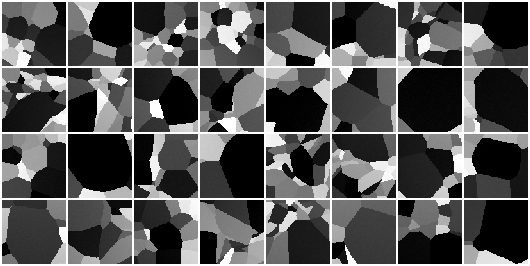

In [20]:
# Generating inference
reverse_diffusion(model, sd, timesteps=ModelConfig.TIMESTEPS, num_images=32, img_shape=ModelConfig.IMG_SHAPE, device=ModelConfig.DEVICE,)